# Фаза 2 • Неделя 10 • Вторник
## Обработка естественного языка
#### Word2Vec • LSTM • Attention

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter

from torchmetrics.classification import BinaryAccuracy
from src.rnn_preprocessing import (
                                data_preprocessing, 
                                preprocess_single_string, 
                                padding, 
                                get_words_by_freq
                                )
from src.train_rnn import train_attention_lstm

In [5]:
# Лучше всего установить такую же версию
print(gensim.__version__)

4.3.1


## Загрузка и препроцессинг данных

Общая схема обычная: 
1. Загружаем данные
2. Столбец с отзывами предобрабатываем (стоп-слова, числа, теги – все гиперпараметр)
3. Обучаем `word2vec` на наших данных и создаем собственный `embedding`-слой из векторов `w2v`
4. Преобразуем слова в индексы и делаем `padding`
5. Разделяем на обучение и валидацию

In [6]:
df = pd.read_csv('data/imdb.csv')
reviews = df['review'].tolist()
preprocessed = [data_preprocessing(review) for review in reviews]

In [7]:
preprocessed[10]

'phil alien one quirky films humour based around oddness everything rather actual punchlinesat first odd pretty funny movie progressed didnt find jokes oddness funny anymoreits low budget film thats never problem pretty interesting characters eventually lost interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [8]:
# Анализируем частоты слов и выбираем только те, которые встречаются чаще порога
corpus = [word for text in preprocessed for word in text.split()]
sorted_words = Counter(corpus).most_common()
sorted_words = get_words_by_freq(sorted_words, 200)
sorted_words[-10:]

[('loads', 201),
 ('myers', 201),
 ('walken', 201),
 ('failing', 201),
 ('honesty', 201),
 ('dozens', 201),
 ('superficial', 201),
 ('reunion', 201),
 ('vegas', 201),
 ('todd', 201)]

In [9]:
# Создаем словарь слово: индекс
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
# vocab_to_int

In [10]:
list(vocab_to_int.items())[:10]

[('movie', 1),
 ('film', 2),
 ('one', 3),
 ('like', 4),
 ('good', 5),
 ('even', 6),
 ('would', 7),
 ('time', 8),
 ('really', 9),
 ('see', 10)]

In [11]:
# Конвертируем слова в индексы
reviews_int = []
for text in preprocessed:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preprocessed[0])

[3, 1792, 934, 56, 3185, 284, 347, 2997, 107, 478, 467, 19, 57, 3068, 3185, 50, 469, 180, 107, 545, 52, 1589, 41, 41, 2338, 1324, 274, 469, 3227, 244, 231, 351, 3185, 238, 2396, 932, 2460, 1234, 418, 2354, 1070, 2804, 296, 211, 3533, 418, 234, 2299, 222, 34, 126, 7, 45, 166, 1160, 41, 547, 91, 159, 154, 432, 2818, 698, 84, 1131, 2332, 968, 698, 1269, 698, 58, 846, 87, 19, 284, 43, 103, 3068, 1435, 2049, 286, 45, 1406, 174, 1321, 1110, 3185, 88, 211, 1931, 1943, 469, 469, 2774, 377, 496, 14, 140, 13, 627, 688, 539, 1070, 547, 435, 802, 1842, 1070, 440, 56, 3185, 98, 300, 3566, 3085, 14, 1073, 3822, 389]
one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section priso

Формируем вход для Word2Vec – это вложенный список формата: 

```python
[
    ['это', 'первый', 'отзыв'],
    ['это', 'второй', 'отзыв']
]
```

Формируем данные для обучения word2vec. Будем бежать по всем отзывам и словам внутри отзывов, если они есть в словаре – добавляем их в список, если нет – пропускаем. 

In [12]:
w2v_input = []
for review in preprocessed:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(f'Total reviews: {len(w2v_input)}')
print(f'Random review for word2vec: {w2v_input[np.random.randint(0, 50000)]}')

Total reviews: 50000
Random review for word2vec: ['love', 'war', 'happen', 'side', 'iron', 'looking', 'love', 'strong', 'west', 'war', 'often', 'poignant', 'say', 'realistic', 'film', 'much', 'war', 'love', 'soviet', 'mr', 'era', 'also', 'reminds', 'us', 'best', 'war', 'movies', 'necessarily', 'made', 'millions', 'spent', 'special', 'effects', 'movie', 'classic', 'soviet', 'cinema', 'outstanding', 'picture', 'one', 'greatest', 'human', 'war']


In [13]:
VOCAB_SIZE = len(vocab_to_int) + 1  # размер словаря вместе с токеном padding
EMBEDDING_DIM = 64 # embedding_dim 

In [14]:
# Обучим Word2Vec
wv = Word2Vec(
    vector_size=EMBEDDING_DIM # размерность вектора для слова
    )
# Сначала word2vec составляет словарь
wv.build_vocab(w2v_input)
print(f'Total reviews: {wv.corpus_count}')

Total reviews: 50000


In [15]:
# Далее обучаем
wv.train(
    corpus_iterable=w2v_input, 
    total_examples=wv.corpus_count, 
    epochs=10
    );

In [16]:
# Похожесть слов
print(wv.wv.similarity('film', 'movie'))
print(wv.wv.similarity('film', 'car'))
print(wv.wv.similarity('cat', 'dog'))

# Близкие слова
print(wv.wv.similar_by_word('movie'))

0.7811417
-0.23555078
0.7504934
[('film', 0.7811416387557983), ('moviei', 0.7725147604942322), ('flick', 0.692772388458252), ('movies', 0.6665305495262146), ('really', 0.5904151201248169), ('thing', 0.5849486589431763), ('moviethe', 0.5822253227233887), ('honestly', 0.5431023240089417), ('sequel', 0.5270323753356934), ('actually', 0.5249571204185486)]


Теперь нам нужно зафиксировать векторы, которые для нас построила модель выше, и передать их на «хранение» в слой Embedding. В таком случае, если вектора уже получены, слой не будет обучаться, а будет по запросу «доставать векторы из тех данных, которые мы в него передадим». 

In [17]:
wv.wv['cat']

array([-1.0492187 ,  1.7325034 ,  1.0122901 , -1.7775537 , -0.15206759,
       -0.34927136,  1.5709175 , -0.80328715, -1.9341474 ,  0.77999204,
       -1.4403139 , -0.1366844 , -1.2678053 , -0.03769841,  2.8276155 ,
       -1.8530195 , -0.7339546 ,  0.29023632,  0.05289092, -0.0946172 ,
        0.20760712,  0.9329735 ,  1.1278582 , -1.688406  , -1.845838  ,
        3.2809277 , -1.556249  , -0.5533643 , -1.1487509 ,  0.34349734,
       -1.8408974 , -1.3578523 ,  1.3001295 , -0.6027932 , -0.13170649,
       -0.6242253 , -2.1248076 ,  2.4099467 , -1.9206221 , -1.1574667 ,
       -0.56492776,  0.96797067,  0.18334982,  0.8265372 , -0.0909607 ,
       -0.00466083,  0.24533461,  1.2160232 ,  0.5724257 , -0.09939807,
       -0.08588637,  0.34014767,  1.8308814 ,  1.0176563 , -1.2642443 ,
        1.4774233 ,  0.21195787, -0.05716217, -0.50203365,  4.0636263 ,
       -1.4624686 , -0.37801266, -0.7134766 , -0.32143584], dtype=float32)

In [18]:
vocab_to_int.items()

dict_items([('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('even', 6), ('would', 7), ('time', 8), ('really', 9), ('see', 10), ('story', 11), ('much', 12), ('well', 13), ('get', 14), ('great', 15), ('bad', 16), ('also', 17), ('people', 18), ('first', 19), ('dont', 20), ('movies', 21), ('made', 22), ('make', 23), ('films', 24), ('could', 25), ('way', 26), ('characters', 27), ('think', 28), ('watch', 29), ('many', 30), ('seen', 31), ('two', 32), ('character', 33), ('never', 34), ('love', 35), ('acting', 36), ('little', 37), ('plot', 38), ('best', 39), ('know', 40), ('show', 41), ('life', 42), ('ever', 43), ('better', 44), ('say', 45), ('still', 46), ('scene', 47), ('end', 48), ('man', 49), ('scenes', 50), ('something', 51), ('go', 52), ('back', 53), ('real', 54), ('im', 55), ('watching', 56), ('thing', 57), ('doesnt', 58), ('didnt', 59), ('actors', 60), ('years', 61), ('actually', 62), ('though', 63), ('funny', 64), ('makes', 65), ('another', 66), ('find', 67), ('nothin

In [19]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть в word2vec, 
# достаем его вектор; если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f'{e}: word: {word}')
        
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f'Number of words x EMEDDING_DIM: {embedding_matrix.shape}')

Number of words x EMEDDING_DIM: (3914, 64)


In [20]:
# Применяем padding
padded = padding(review_int=reviews_int, seq_len=64)
print(padded[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  135 3585  388    1   11 3366  917  241
   34  106   75  367   31  114  133   61  720  138  817 1552  397 1793
    3  245 2011  466 2857  223  406    4  349   65  144   29 2684  486
  583 1314   92  711 2489 3487 3101    1]


In [21]:
# train_test split + label encoding 
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(
        df['sentiment'], 
        drop_first=True
    ).values.astype('int'), test_size=0.2, random_state=1)

In [22]:
BATCH_SIZE = 64

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [23]:
# посмотрим, что внутри
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: BATCH_SIZE x SEQ_LEN', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y[:10])

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 64])
Sample input: 
 tensor([[   0,    0,    0,  ...,  135,    9,  239],
        [ 317, 1677,  982,  ...,    3,   10, 1164],
        [  78,  262,  715,  ..., 2151,  413,    2],
        ...,
        [   0,    0,    0,  ..., 3870,   84,   13],
        [2371, 1526,  233,  ...,    4,  630, 2168],
        [1333,   17, 3017,  ...,   76,  124,   54]])
Sample input: 
 tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1]])


In [24]:
device = 'cpu' #cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
HIDDEN_SIZE = 32

In [26]:
class ConcatAttention(nn.Module):
    def __init__(
            self, 
            hidden_size: int = HIDDEN_SIZE
            ) -> None:
        
        super().__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.align  = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.tanh   = nn.Tanh()

    def forward(
            self, 
            lstm_outputs: torch.Tensor, # BATCH_SIZE x SEQ_LEN x HIDDEN_SIZE
            final_hidden: torch.Tensor  # BATCH_SIZE x HIDDEN_SIZE
            ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        att_weights = self.linear(lstm_outputs)
        # print(f'After linear: {att_weights.shape, final_hidden.unsqueeze(2).shape}')
        att_weights = torch.bmm(att_weights, final_hidden.unsqueeze(2))
        # print(f'After bmm: {att_weights.shape}')
        att_weights = F.softmax(att_weights, dim=1)
        # print(f'Ouputs shape: {lstm_outputs.transpose(1, 2).shape}, After softmax: {att_weights.unsqueeze(2).shape}')
        cntxt       = torch.bmm(lstm_outputs.transpose(1, 2), att_weights)
        # print(f'Context: {cntxt.shape}, final shape: {final_hidden.unsqueeze(2).shape}')
        concatted   = torch.cat((cntxt, final_hidden.unsqueeze(2)), dim=1)
        # print(f'Concatted: {concatted.shape}')
        att_hidden  = self.tanh(self.align(concatted.squeeze(-1)))
        # print(f'Att Hidden: {att_hidden.shape}')
        return att_hidden, att_weights

# Test on random numbers
ConcatAttention()(torch.randn(BATCH_SIZE, 64, HIDDEN_SIZE), torch.randn(BATCH_SIZE, HIDDEN_SIZE))

(tensor([[ 0.5946, -0.6372,  0.2139,  ...,  0.7159,  0.3768,  0.2386],
         [-0.7760, -0.9092,  0.1157,  ...,  0.8526,  0.4341,  0.4526],
         [-0.1349, -0.5675, -0.8992,  ...,  0.1740,  0.2960,  0.0788],
         ...,
         [ 0.5309, -0.6548,  0.0998,  ...,  0.3640,  0.2889,  0.3814],
         [-0.1983, -0.6369, -0.2053,  ...,  0.1122, -0.2241, -0.6981],
         [ 0.0043, -0.3869, -0.3175,  ..., -0.2167,  0.7095, -0.7202]],
        grad_fn=<TanhBackward0>),
 tensor([[[1.3212e-03],
          [2.9416e-04],
          [2.9200e-04],
          ...,
          [4.0518e-02],
          [3.8909e-03],
          [5.8072e-02]],
 
         [[4.1186e-07],
          [4.4530e-06],
          [1.7786e-04],
          ...,
          [4.4715e-05],
          [3.4884e-07],
          [1.4395e-04]],
 
         [[3.2075e-05],
          [7.9766e-04],
          [5.6402e-05],
          ...,
          [3.8752e-05],
          [8.1030e-05],
          [5.5502e-05]],
 
         ...,
 
         [[1.6870e-02],

In [27]:
attention = ConcatAttention(HIDDEN_SIZE)

In [28]:
tu.get_model_summary(attention, torch.randn(16, 32, HIDDEN_SIZE), torch.randn(16, HIDDEN_SIZE))

Layer       Kernel       Output      Params       FLOPs
0_linear   [32, 32]   [16, 32, 32]    1,056   1,032,192
1_align    [64, 32]       [16, 32]    2,080      65,024
2_tanh            -       [16, 32]        0       2,560
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
Total FLOPs: 1,099,776 / 1.10 MFLOPs
-------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.21


In [29]:
SEQ_LEN = 32

In [30]:
class LSTMConcatAttention(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_SIZE, batch_first=True)
        self.attn = ConcatAttention(HIDDEN_SIZE)
        self.clf = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 128),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        att_hidden, att_weights = self.attn(outputs, h_n.squeeze(0))
        out = self.clf(att_hidden)
        return out, att_weights

In [31]:
model_concat = LSTMConcatAttention()
DEVICE='cpu'
criterion = nn.BCEWithLogitsLoss()
optimizer_concat = torch.optim.RMSprop(model_concat.parameters(), lr=0.001)

metric = BinaryAccuracy() #BinaryAccuracy().to(device)

In [32]:
train_losses, val_losses, train_metric, val_metric, rnn_time = train_attention_lstm(
    3, model_concat, train_loader, valid_loader, optimizer_concat, criterion, metric
)

Epoch 1
train_loss : 0.3758 val_loss : 0.3403
train_accuracy : 0.83 val_accuracy : 0.85
Epoch 2
train_loss : 0.3331 val_loss : 0.3377
train_accuracy : 0.86 val_accuracy : 0.85
Epoch 3
train_loss : 0.3168 val_loss : 0.3400
train_accuracy : 0.86 val_accuracy : 0.86


In [35]:
vocab_to_int['<pad>'] = 0

In [36]:
int_to_vocab = {j:i for i, j in vocab_to_int.items()}

In [62]:
def plot_and_predict(review: str, SEQ_LEN: int, model: nn.Module):
    """Predict class and draw word attention scores 

    Args:
        review (str): Review text
        SEQ_LEN (int): sequence length
        model (nn.Module): trained model
    """
    print(f'Initial sequence: {review}')
    inp = preprocess_single_string(review, SEQ_LEN, vocab_to_int)
    print(f'Preprocessed sequence: {inp}')
    model.eval()
    with torch.inference_mode():
        pred, att_scores = model(inp.long().unsqueeze(0))
    print(f'Attention scores: {att_scores.cpu().numpy().flatten()}')
    
    # create figure
    plt.figure(figsize=(12, 4))
    # draw barplot
    plt.bar(np.arange(len(inp)), att_scores.cpu().numpy().flatten())
    # set ylimits
    plt.ylim(0, max(att_scores.cpu().numpy()[0])+.2)
    # set xticks: seq_len positions with words as labels
    plt.xticks(
        ticks = np.arange(len(inp)), 
        labels = [int_to_vocab[x.item()] for x in inp]  # type: ignore
        );
    # Plot title
    plt.title(f'Pred class {pred.sigmoid().round().item()}')
    # set positions and labels under bars
    score_label_shift = len(inp)*.02
    for x, y in zip(np.arange(len(inp)), att_scores.detach().cpu().numpy()[0]):
        plt.text(x-score_label_shift, y+.005, s=f'{y[0]:.2f}')

Initial sequence: Worst movie I have ever seen
Preprocessed sequence: tensor([  0.,   0., 143.,   1.,  43.,  31.])
Attention scores: [0.0867497  0.07859637 0.17828535 0.23698421 0.18648814 0.23289628]


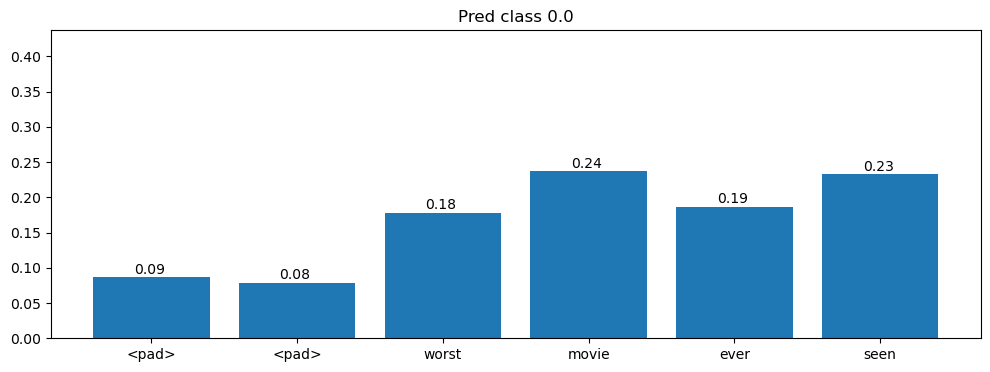

In [63]:
review = "Worst movie I have ever seen"
plot_and_predict(
    review = review, 
    SEQ_LEN=len(review.split()),
    model = model_concat
)
